if you just want to plot activity from file address_origFile, set import_fromExternalFile= False
if you need to import results from another file first set import_fromExternalFile= True and then run the script with False

In [1]:
import h5py
import scipy.ndimage as sim
import numpy as np
from scipy import linalg as LA
import math
from scipy.ndimage import affine_transform
from scipy import ndimage
import copy
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

In [19]:
def droptop5perc(velocityVec0,thresh=0.05):
    #drops the highest 5 percent
    velocityVec = velocityVec0.copy()
    Sort = np.argsort(velocityVec)
    velocityVec_s = velocityVec[Sort]
    velocityVec_s = velocityVec_s[velocityVec_s>0]
    upperBound = np.min(velocityVec_s[-int(len(velocityVec_s)*thresh):])#mean of the lowwest dropTresh percent of the activity
    above_thresh = (velocityVec > upperBound)
    velocityVec[above_thresh]=0
    velocityVec[above_thresh]=0
    return velocityVec
def dropbottom5perc(velocityVec0,thresh=0.05):
    velocityVec = velocityVec0.copy()
    Sort = np.argsort(velocityVec)
    velocityVec_s = velocityVec[Sort]
    velocityVec_s = velocityVec_s[(velocityVec_s>0) + (velocityVec_s<0)]
    lowerBound = np.max(velocityVec_s[:int(len(velocityVec_s)*thresh)])#mean of the lowwest dropTresh percent of the activity
    below_thresh = (velocityVec < lowerBound)
    #print("lowerBound"+str(lowerBound))
    velocityVec[below_thresh]=0
    velocityVec[below_thresh]=0
    return velocityVec


def smooth_locations(rowsArr_floatloc1,sig=1):
    smoothed_arr=np.zeros(np.shape(rowsArr_floatloc1))
    smoothed_arr = gaussian_filter((rowsArr_floatloc1), sigma=sig)
    return smoothed_arr 

def fourier_freq(signal):
    # Compute the Fourier Transform
    if np.any(np.isnan(signal)) or np.any(np.isinf(signal)):
        print("Signal contains NaN or Inf values.")
    t = np.linspace(0, 1, len(signal), endpoint=False)
    fourier_transform = np.fft.fft(signal)

    # Compute the two-sided and one-sided spectrum
    two_sided_spectrum = np.abs(fourier_transform)
    one_sided_spectrum = two_sided_spectrum[:len(t) // 2]

    # Frequency bins
    freq_bins = np.fft.fftfreq(len(t), d=(t[1] - t[0]))
    one_sided_freq_bins = freq_bins[:len(t) // 2]

    # Plot the original signal
    plt.figure()
    plt.title("Original Signal")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.plot(t, signal)
    plt.show()

    # Plot the one-sided spectrum
    plt.figure()
    plt.title("One-sided Spectrum")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Amplitude")
    plt.plot(one_sided_freq_bins, one_sided_spectrum)
    plt.show()
    return freq_bins,one_sided_spectrum

In [3]:
import_fromExternalFile = False

In [4]:
#run this if you want to import predictions from another file
if import_fromExternalFile:
    Extern_File = '/mnt/hdd/Mahsa/movies/Picking_your_brain/ananya_worms/Recording2023_07_20/results/July13_205626_NNres2.h5'
    hext=h5py.File(Extern_File ,'r')

In [5]:
address_origFile = '/mnt/hdd/Mahsa/movies/Picking_your_brain/ananya_worms/Recording2023_07_20/W6hne.h5'
#'/mnt/hdd/Mahsa/movies/Picking_your_brain/ananya_worms/recording2023_07_13/205626.h5'
address_saveFileheat = address_origFile.split('.')[0]+'heatmap.png'
address_saveFileneu = address_origFile.split('.')[0]+'neur.png'

In [6]:
h5=h5py.File(address_origFile,'r+')
time_vec = np.arange((h5.attrs["T"]))*1.045


In [7]:
#if you need to import result from another file do it here
if import_fromExternalFile:
    if 'pointdat' in h5.keys():
        print(np.shape(h5['pointdat']))
        del h5['pointdat']
    h5.create_dataset('pointdat', data=hext['pointdat'])
    h5.close()
    hext.close()

In [8]:
A = np.array(h5['pointdat'])
shape = np.shape(A)
F,N,coord = np.nonzero(~np.isnan(A))

In [9]:
ci_interr_gt=np.array(h5["ci_int"])
ci_int_gt=ci_interr_gt[:,:,0]
existing=np.sum(np.isnan(ci_int_gt)!=1,axis=1)>2
ci_int_gt=ci_int_gt[existing]



In [10]:
num_odor_pulses = int((np.max(time_vec)-np.min(time_vec))/60)
List_of_odor_pulses = np.ones(num_odor_pulses)
List_of_xticks = np.ones(num_odor_pulses)
for o in range(num_odor_pulses):
    List_of_odor_pulses[o] = np.min(time_vec)+60*o+40
    List_of_xticks[o] = np.min(time_vec)+60*o

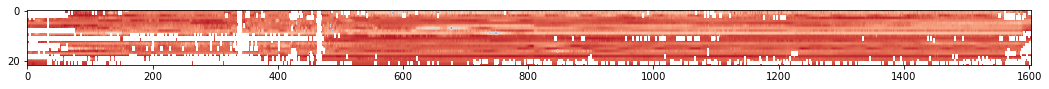

In [11]:


plt.figure(figsize=(18,8))
def trim_ci_int(ci_int):
    m=np.nanmin(ci_int,axis=1)
    return (ci_int-m[:,None])/(np.nanmax(ci_int,axis=1)-m)[:,None]
trimmed_ci_int=trim_ci_int(ci_int_gt)
plt.imshow(trimmed_ci_int**(0.2),vmin=0,vmax=1,cmap="coolwarm")
plt.gca().set_aspect(4)
plt.savefig(address_saveFileheat)
plt.show()


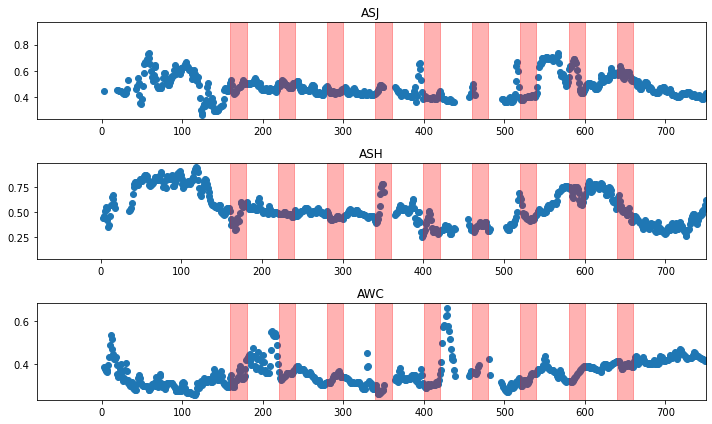

In [13]:
annotated=True#whether you want to plot all the neurons or a subset of them
drop_outliers=False
cut_out_2NN = True
if annotated:
    neurons_to_plot =[4,17,18]
    neuronNum = len(neurons_to_plot)
else:    
    neuronNum = np.shape(trimmed_ci_int)[0]
    neurons_to_plot = range(1,neuronNum+1)

fig, axs = plt.subplots(len(neurons_to_plot), 1, figsize=(10, neuronNum * 2))
count=0
#[2,3,4,5,7,8,10,11]
annotation = ['ASJ','ASH','AWC','AWB','sensory','sensory','ASE']
for n in neurons_to_plot:
    # Extract the nonzero values of the row
    Act_n  = trimmed_ci_int[n-1,:]
    if drop_outliers:
        seq = (np.nonzero(dropbottom5perc(droptop5perc(trimmed_ci_int[n-1,:]))))[0]
    else:
        seq =np.nonzero(trimmed_ci_int[n-1,:])
    row_nonzero = Act_n[seq]
    time_nonzero = time_vec[seq]
    if len(time_nonzero)>0:
        if annotated:
            axs[count].set_title(annotation[count])
        else:    
            axs[count].set_title("neuron {}".format(n))
        axs[count].scatter(time_nonzero+3,smooth_locations(row_nonzero))
        #FF = fourier_transform(time_nonzero+3,smooth_locations(row_nonzero))
        for o in List_of_odor_pulses:
            if o>120 and o<660:
                axs[count].axvspan(o,o+20,color='red',alpha=0.3)
            if o>780 and o<1140:
                axs[count].axvspan(o,o+20,color='blue',alpha=0.3)   
            if o>1260 and o<1660:
                axs[count].axvspan(o,o+20,color='green',alpha=0.3) 
        if cut_out_2NN:        
            axs[count].set_xlim(right=750)
            #axs[0].set_ylim(top=0.3)
            #axs[1].set_ylim(top=0.6)
        count=count+1
        
        
plt.tight_layout()
plt.savefig(address_saveFileneu)
plt.show()

Signal contains NaN or Inf values.


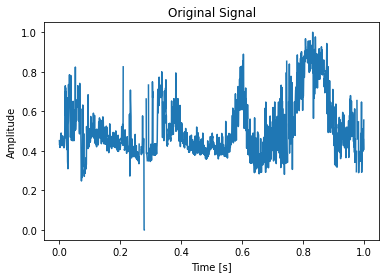

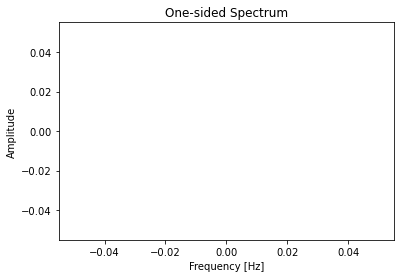

4
[ 0.  1.  2. ... -3. -2. -1.]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan na

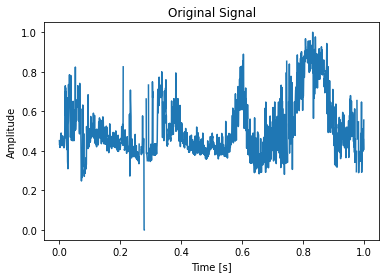

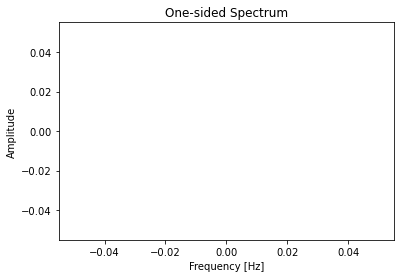

Signal contains NaN or Inf values.


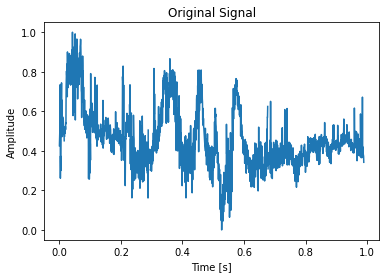

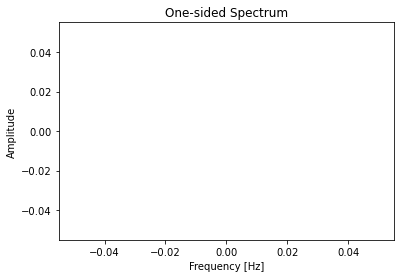

17
[ 0.  1.  2. ... -3. -2. -1.]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

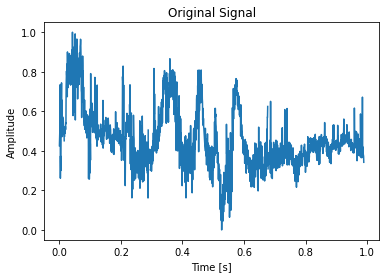

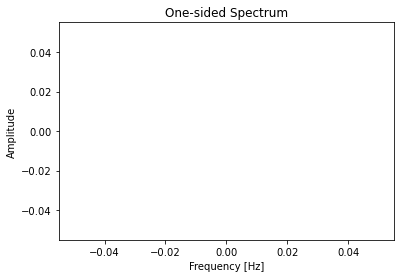

Signal contains NaN or Inf values.


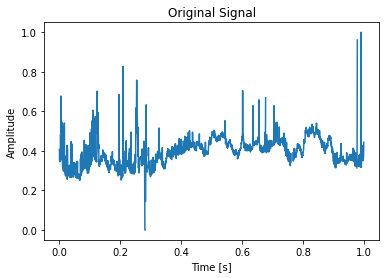

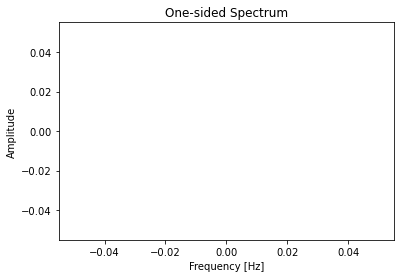

18
[ 0.  1.  2. ... -3. -2. -1.]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

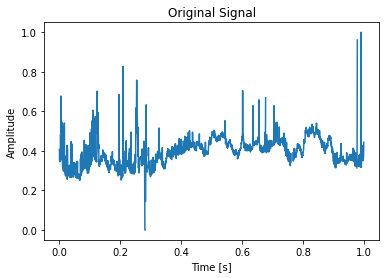

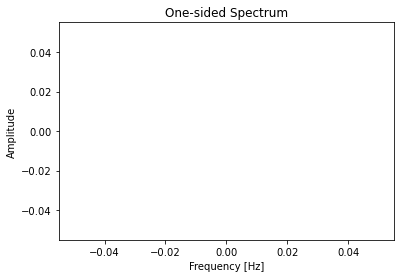

In [20]:
for n in neurons_to_plot:
    signal = trimmed_ci_int[n-1,:]
    f,v =  fourier_freq(signal)
    print(n)
    print(f)
    print(v)
    fourier_freq(signal)

In [18]:
np.fft.fft(trimmed_ci_int[n-1,:])

array([nan+nanj, nan+nanj, nan+nanj, ..., nan+nanj, nan+nanj, nan+nanj])

In [92]:
h5.close()

In [29]:
#change point masks to volumes
#time_vec = np.zeros((h5.attrs["T"]))
time_vec = np.arange((h5.attrs["T"]))
Activity = np.zeros((shape[1],h5.attrs["T"]))
mask = np.zeros((h5.attrs["W"],h5.attrs['H']))
mask_final = np.full((h5.attrs["W"],h5.attrs['H'],h5.attrs['D']), False, dtype=bool)
Fbefore=F[0]
for f in range(len(F)): 
    #time_vec[F[f]] = np.array(h5[str(F[f])+'/time'])
    if h5.attrs["C"]==2:
        frame = np.array(h5[str(F[f])+'/frame'])[1]
        frameR= np.array(h5[str(F[f])+'/frame'])[0]
    else:
        frame = np.array(h5[str(F[f])+'/frame'])[0]
    #if not F[f]==Fbefore:
    mask = np.zeros((h5.attrs["W"],h5.attrs['H']))
    center = (int(A[F[f],N[f],0]), int(A[F[f],N[f],1]))#,A[f,n,2])
    axis_lengths = (6, 4)#10,7
    # Compute the indices of the oval region
    x_indices = np.arange(h5.attrs["W"])
    y_indices = np.arange(h5.attrs["H"])
    xx, yy = np.meshgrid(x_indices, y_indices)
    oval_mask = (((xx - center[0]) / axis_lengths[0])**2 + ((yy - center[1]) / axis_lengths[1])**2) <= 1
    # Set the values in the oval region to 1
    mask[oval_mask.transpose()] = 1
    
    #fr_ind = np.nonzero(np.unique(F)==F[f])[0]
    
    
    mask_final[:,:,int(A[F[f],N[f],2])]=oval_mask.transpose()
    mask_final[:,:,int(A[F[f],N[f],2]-1)]=oval_mask.transpose()
    mask_final[:,:,int(A[F[f],N[f],2]+1)]=oval_mask.transpose()
    if h5.attrs["C"]==2:
        Activity[N[f],F[f]]=np.mean(frame[mask_final])/np.mean(frameR[mask_final])
    else:
        Activity[N[f],F[f]]=np.mean(frame[mask_final])


In [ ]:
if "ci_int_mask" in h5.keys():
    del h5["ci_int_mask"]
h5.create_dataset("ci_int_mask",data=Activity)

622
602
601
602
602
602
601
626
602
601
602
602
602
601
602
602
602
601
602
600
622
624
602
626


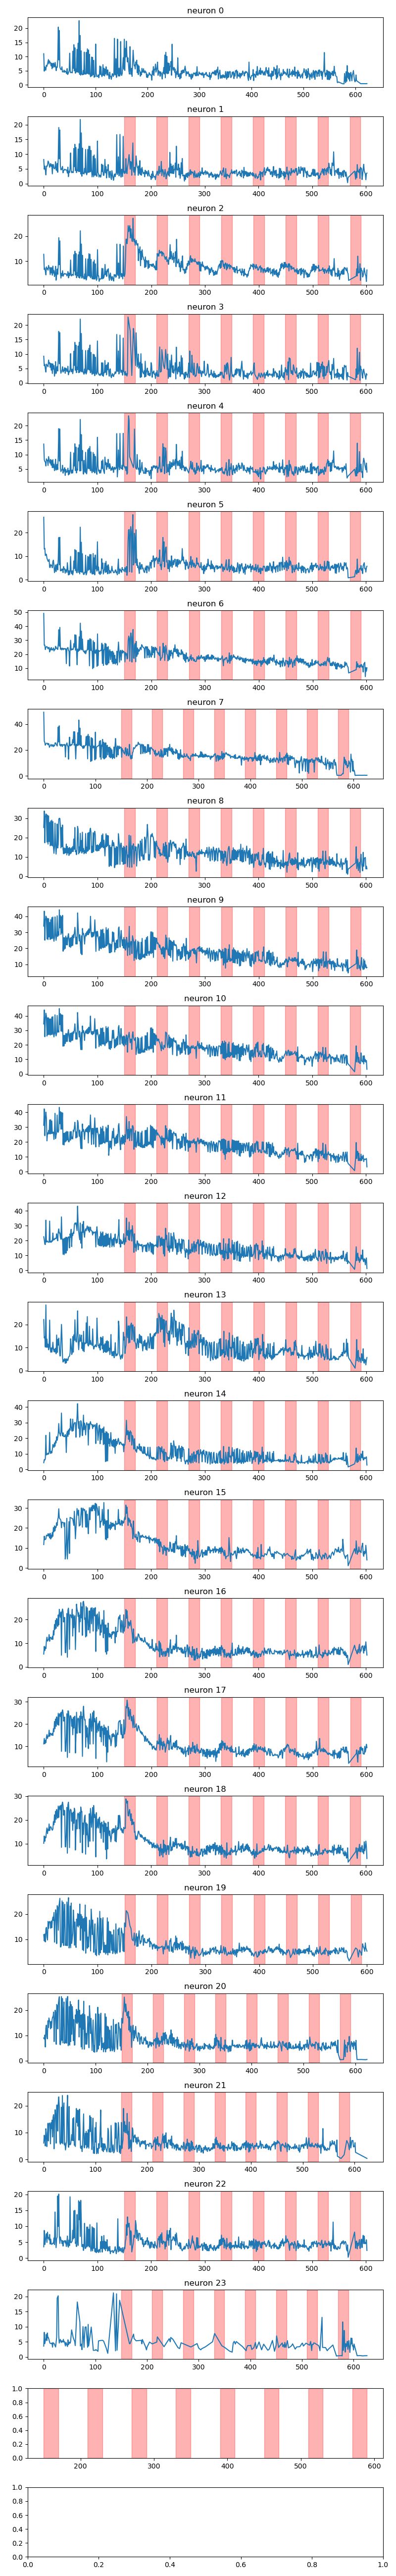

In [12]:
#plot activity
# Plot the nonzero values of each row in separate plots
num_rows = Activity.shape[0]
fig, axs = plt.subplots(num_rows, 1, figsize=(8, num_rows * 2))
# Iterate over each row of the matrix
count=0

for row in Activity:
    # Extract the nonzero values of the row
    row_nonzero = row[np.nonzero(row)]
    time_nonzero = time_vec[np.nonzero(row)]
    if len(time_nonzero)>0:
        print(np.max(time_nonzero))
        #nonzero_values.append(row_nonzero)
        axs[count].set_title("neuron {}".format(count))
        axs[count].plot(time_nonzero,row_nonzero)
        count=count+1
        for o in List_of_odor_pulses:
            if o>120 and o<660:
                axs[count].axvspan(o,o+20,color='red',alpha=0.3)
            if o>780 and o<1140:
                axs[count].axvspan(o,o+20,color='blue',alpha=0.3)   
            if o>1260 and o<1660:
                axs[count].axvspan(o,o+20,color='green',alpha=0.3) 
       
plt.tight_layout()
plt.show()

In [192]:
#alternative way of computing activity from masks
#time_vec = np.zeros((h5.attrs["T"]))
time_vec = np.arange((h5.attrs["T"]))
Activity = np.zeros((shape[1],h5.attrs["T"]))
mask = np.zeros((h5.attrs["W"],h5.attrs['H']))
mask_final = np.full((h5.attrs["W"],h5.attrs['H'],h5.attrs['D']), False, dtype=bool)
Fbefore=F[0]
for f in range(len(F)): 
    #time_vec[F[f]] = np.array(h5[str(F[f])+'/time'])
    frame = np.array(h5[str(F[f])+'/frame'])[0]
    mask = np.array(h5[str(F[f])+'/mask'])
    Activity[N[f],F[f]]=np.mean(frame[mask==int(N[f])])


/home/mahsa/anaconda3/envs/EmptyEnviro/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mahsa/anaconda3/envs/EmptyEnviro/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


KeyError: "Unable to open object (object 'mask' doesn't exist)"

In [17]:
h5.close()

In [16]:
del h5['pointdat'] 
h5.copy('helper_NN', 'pointdat')

KeyError: "Couldn't delete link (callback link pointer is NULL (specified link may be '.' or not exist))"

In [16]:
#permute
print(np.shape(ci_int_gt))
ci_int_gt = ci_int_gt[[7,1,6,5,2,4,3,8,9,10,11,12,13],:]
#[1,2,3,4,6,7,9,10,0,5,8]

(16, 1605)


In [17]:
h5.close()

In [68]:
h5.attrs["N_neurons"]=15

In [33]:
print(List_of_odor_pulses)

[ -28.   32.   92.  152.  212.  272.  332.  392.  452.  512.  572.  632.
  692.  752.  812.  872.  932.  992. 1052. 1112. 1172. 1232. 1292. 1352.
 1412. 1472. 1532. 1592.]


In [8]:
point_masks = h5['pointdat']
print(np.shape(point_masks))

(627, 26, 3)


In [14]:
point_masks[:181,25,:] = point_masks[:181,18,:]

In [15]:
point_masks[:181,18,:] = point_masks[:181,18,:]+[5,5,1]

In [16]:
del h5['pointdat']
h5.create_dataset('pointdat',data=point_masks)

<HDF5 dataset "pointdat": shape (627, 26, 3), type "<f8">

In [33]:
address_origFile = '/mnt/hdd/Mahsa/movies/LongRecordings/2023-08-07/123426.h5'
h5=h5py.File(address_origFile,'r+')
time_vec = np.arange((h5.attrs["T"]))*1.045


OSError: Unable to open file (bad local heap signature)